## LC Bulk Fit Test

<br>**Author(s):** Weixiang Yu
<br>**Last run:** 08-28-20
<br>**Short description:** Dev/Test code to run LC fitting in bulk. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys

# use mpl style on github
mpl.rc_file('https://raw.githubusercontent.com/ywx649999311/project_template'
            '/master/%7B%7Bcookiecutter.project_name%7D%7D/src/vis/mpl/yu_basic.rc')

pd.set_option('display.max_columns', 999)
%matplotlib inline

In [3]:
sys.path.insert(0, '../src/')
from fit import *

### 1. Import data \& Test function in module

In [4]:
train_meta = pd.read_csv('../data/plasticc_train_metadata.csv')
train_lc = pd.read_csv('../data/plasticc_train_lightcurves.csv')

lc_test = train_lc[train_lc.object_id == 615]
lc_gps = train_lc.groupby(by=['object_id'])

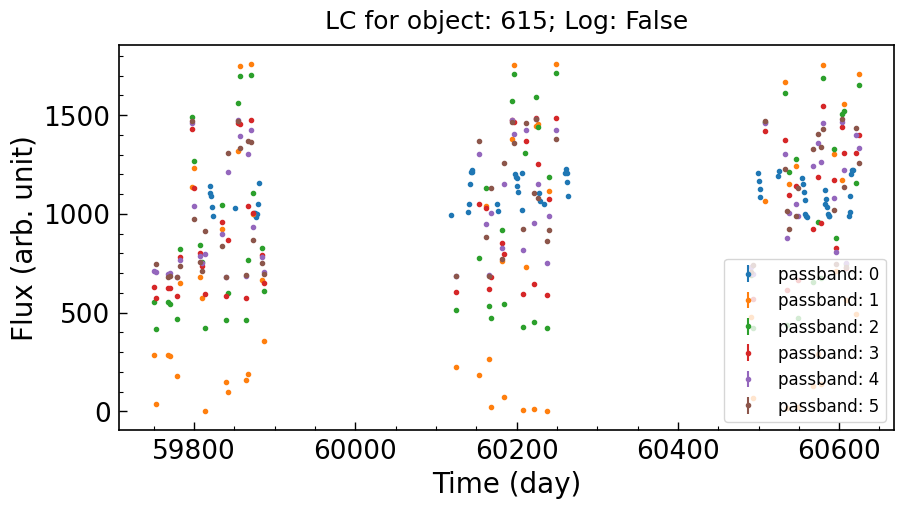

In [5]:
plot_lc(lc_test)

array([615.        ,  84.70016818, 596.25663506, 450.12818567,
       330.82833476, 287.52435152, 291.89674376,   4.58497238,
         1.14171456,   1.76637064,   2.28554875,   3.30164232,
         3.21460568])

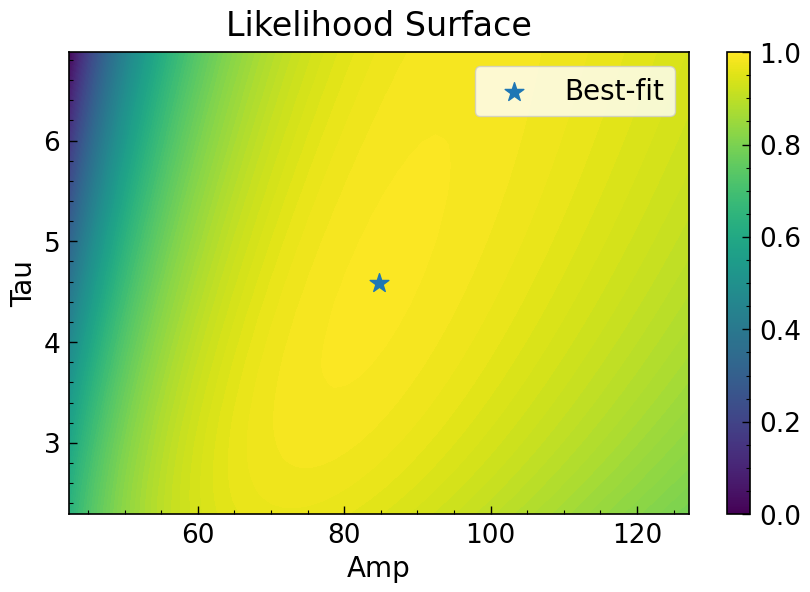

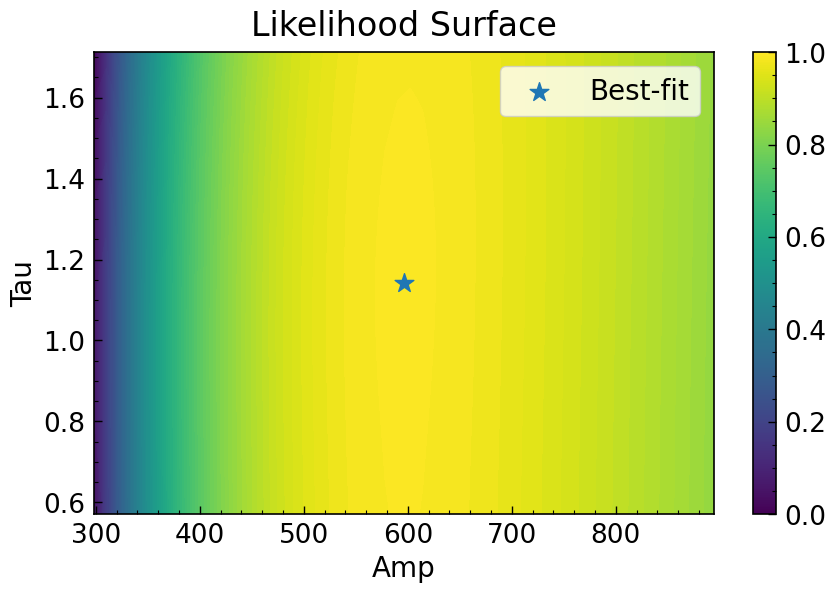

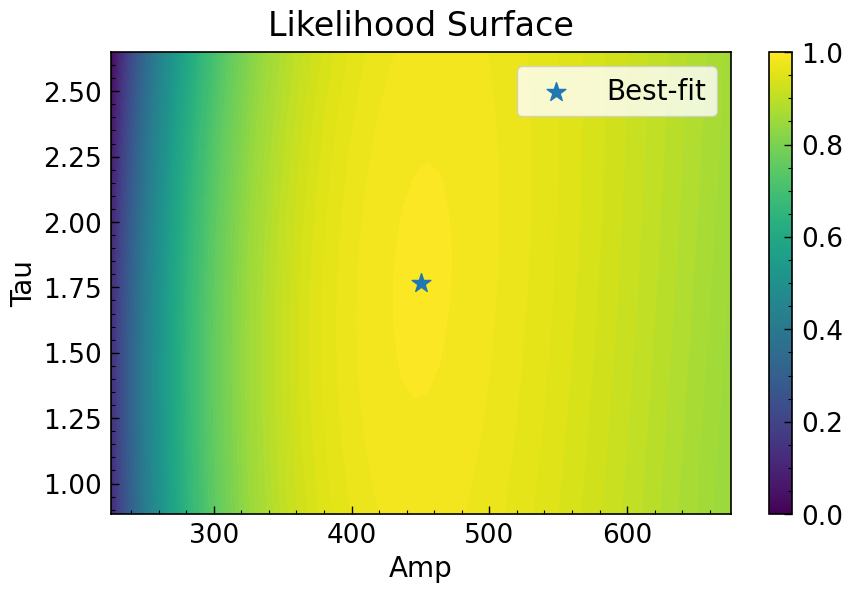

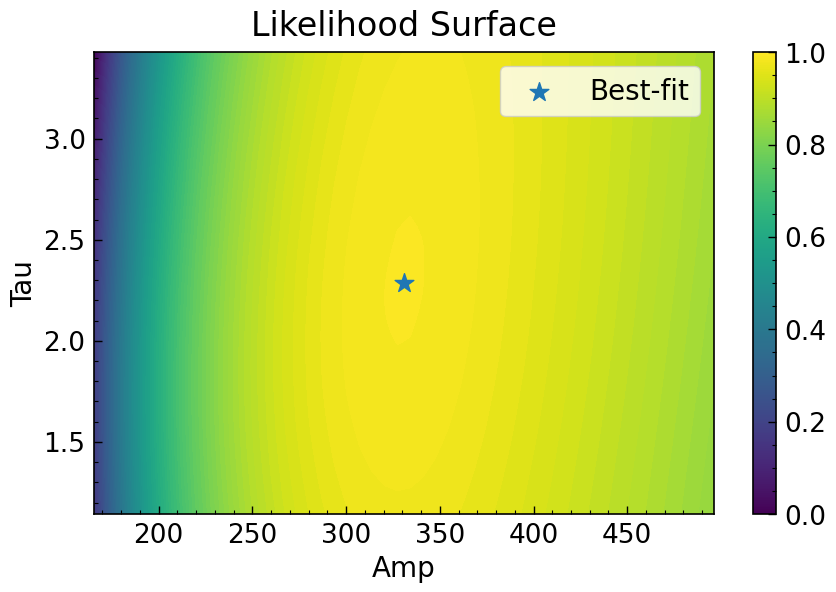

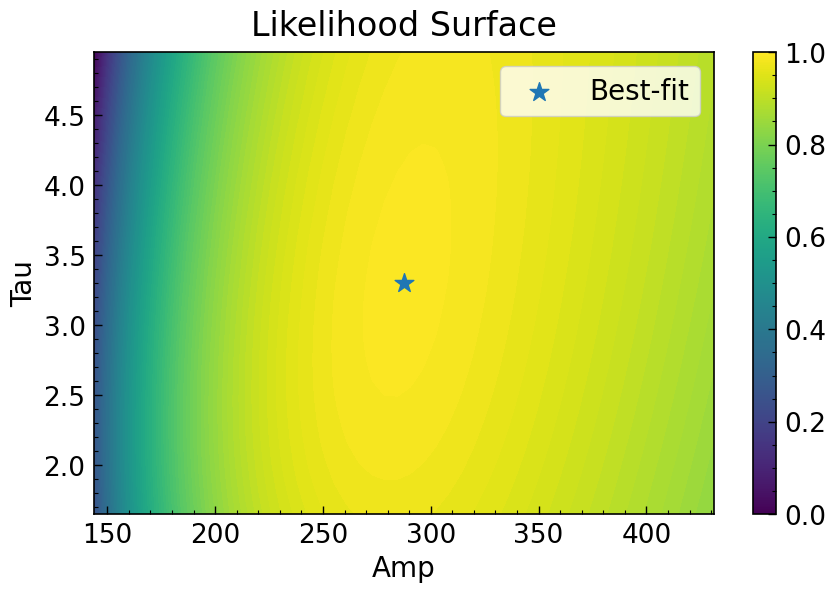

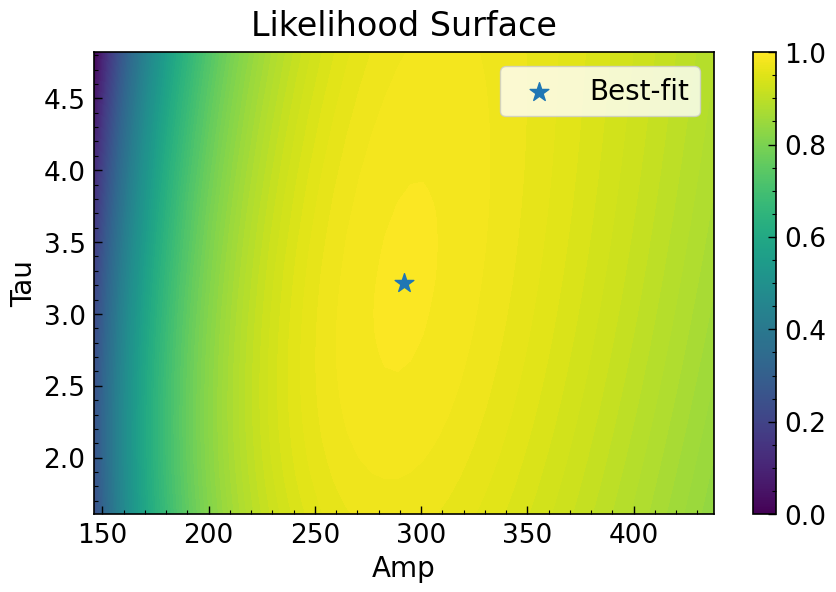

In [6]:
lc_fit_data(lc_test, plot=True)

### 2. Test save the result more frequently
Basically run fitting in chuncks (e.g., every 10000) and save after finishing each chunk. 

In [7]:
print(f'Total number of LC in training data: {len(train_meta)}')

Total number of LC in training data: 7848


#### 2.1 Test with train_data

In [8]:
import dask
from dask.distributed import Client
client = Client()

In [9]:
bands = ['u', 'g', 'r', 'i', 'z', 'y']
gps_keys = list(lc_gps.groups.keys())

In [11]:
# create col names
cols = ['object_id']
for band in bands:
    cols.append(f'drw_amp_{band}')
for band in bands:
    cols.append(f'drw_tau_{band}')

outDir = './train_result'
if not os.path.exists(outDir): os.mkdir(outDir)
chunk_size = 1000

# loop over all LC, save every 1k
for j in range(int(len(train_meta)/chunk_size)):
    
    total = []
    for i, key in enumerate(gps_keys[j*chunk_size:
                                     j*chunk_size+chunk_size]):
        lc = train_lc[train_lc.object_id == key]
        r = client.submit(lc_fit_data, lc)
        total.append(r)
    
    # combine result returned by dask and save
    total_rt = client.gather(total, errors='skip')
    df = pd.DataFrame(total_rt, columns=cols)
    df['object_id'] = df['object_id'].astype(int)
    df.to_csv(os.path.join(outDir, f'batch_{j}'), index=False)
    print(f'Done with batch: {j}')

Done with batch: 0
Done with batch: 1
Done with batch: 2
Done with batch: 3
Done with batch: 4
Done with batch: 5
Done with batch: 6


#### 2.2 Combine result into one dataframe

In [12]:
from glob import glob

In [13]:
batch_fs = glob(os.path.join(outDir, 'batch_*'))

In [14]:
dfs = []
for f in batch_fs:
    df = pd.read_csv(f)
    dfs.append(df)

df_total = pd.concat(dfs).reset_index(drop=True)

In [16]:
df_total.sort_values(by='object_id').head()

,object_id,drw_amp_u,drw_amp_g,drw_amp_r,drw_amp_i,drw_amp_z,drw_amp_y,drw_tau_u,drw_tau_g,drw_tau_r,drw_tau_i,drw_tau_z,drw_tau_y
2000,615,84.700210,596.256759,450.126585,330.827659,287.524256,291.896513,4.584931,1.141728,1.766343,2.285641,3.301625,3.214593
2001,713,6.910855,5.868170,6.002051,6.071426,6.047398,5.017361,242.156832,203.113608,198.259416,109.926980,118.472571,546.993636
2002,730,0.018316,0.561124,6.125643,9.198237,12.149528,14.135908,0.034885,22.120914,241.215379,202.956896,204.438898,134.463573
2003,745,4.058092,52.525547,58.778466,53.370513,48.623468,33.623209,125.003054,250.827007,327.931802,395.249501,366.633501,227.308236
2004,1124,0.524191,9.455053,27.185101,36.364852,38.071542,29.128619,247.422340,286.913059,346.443070,291.608771,266.977428,169.662901


### 3. Test sending notfication using notify-run
You need to first creat a channel on notfiy.run

In [8]:
from notify_run import Notify

In [34]:
notify = Notify()

In [37]:
notify.send('Hello')